In [3]:
import numpy as np
import xarray as xr
import pickle
import pandas as pd
import time
import os

import datetime
from sys import getsizeof,path

import matplotlib.pyplot as plt
import matplotlib

path.append("../src")
from Splines import CentripetalCatmullRomSpline_splitControls,Spline

import pymc3 as pm
import theano
import theano.tensor as tt


theano.config.gcc_cxxflags = "-Wno-c++11-narrowing"

import arviz as az

# Simple Example - recover control Params

Test values in 5.079s


Only 400 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 6100
Interrupted at 6,099 [3%]: Average Loss = 78.019
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, est_control, sigma_control]


Sampling 4 chains for 400 tune and 400 draw iterations (1_600 + 1_600 draws total) took 134 seconds.
The number of effective samples is smaller than 25% for some parameters.


Compiled and Sampled in 212.798


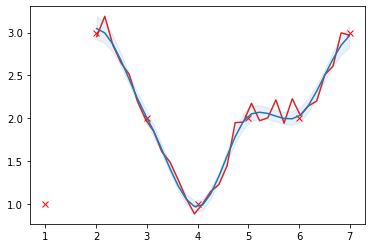

In [2]:
coords = {"cpx":np.array([1,2,3,4,5,6,7],"float64"),"space":np.linspace(2.01,6.99,32,"float64")}
test_control = np.array([1,3,2,1,2,2,3],"float64")
test_spline = Spline(coords["cpx"],tt.cast(test_control,"float64").reshape((1,test_control.shape[0],)))

t1 = time.time()
test_values = test_spline.EvaluateAt(coords["space"]).eval()[:,0]
test_values += np.random.normal(0, .1, coords["space"].shape[0])
t2 = time.time()
print("Test values in %.3fs"%(t2-t1))

plt.plot(coords["space"],test_values,color="tab:red")
plt.plot(coords["cpx"],test_control,"rx")

with pm.Model(coords=coords) as model:
    
    sigma_control = pm.Lognormal("sigma_control",mu=tt.log(2),sigma=1.)
    
    est_control = pm.Normal("est_control",mu=0,sigma=sigma_control,dims=("cpx"))
    est_control = tt.exp(tt.cumsum(est_control))
    
    est_spline = Spline(coords["cpx"],est_control.reshape((1,test_control.shape[0],)))
    est_values = est_spline.EvaluateAt(coords["space"])[:,0]
    
    pm.Deterministic("est_values",est_values)

    sigma_obs = pm.HalfCauchy(name="sigma_obs",beta=2)
    pm.StudentT("est",nu=4,sigma=tt.abs_(est_values+1.)**.5 * sigma_obs,mu=est_values,observed=test_values)
    
    trace = pm.sample(init="advi",return_inferencedata=True,tune=400,draws=400,cores=4,chains=4,max_treedepth=12,target_accept=.95)

t3 = time.time()
print("Compiled and Sampled in %.3f"%(t3-t2))

q = trace.posterior["est_values"].quantile((0.5,.05,.95),["chain","draw"])
plt.plot(coords["space"],q[0],color="tab:blue")
plt.fill_between(coords["space"],q[1],q[2],alpha=.1,color="tab:blue")

array([[<AxesSubplot:title={'center':'est_control'}>,
        <AxesSubplot:title={'center':'est_control'}>]], dtype=object)

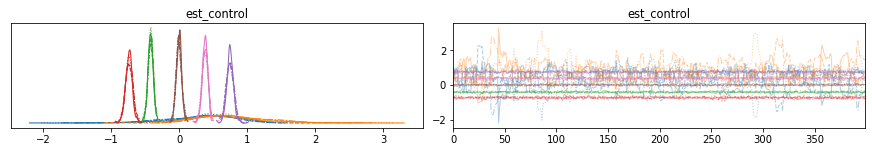

In [4]:
az.plot_trace(trace.posterior["est_control"])

array([[<AxesSubplot:title={'center':'sigma_control'}>,
        <AxesSubplot:title={'center':'sigma_control'}>]], dtype=object)

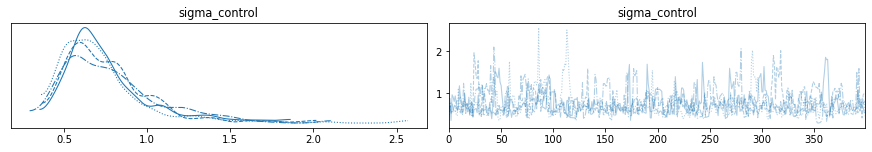

In [5]:
az.plot_trace(trace.posterior["sigma_control"])

array([[<AxesSubplot:title={'center':'sigma_obs'}>,
        <AxesSubplot:title={'center':'sigma_obs'}>]], dtype=object)

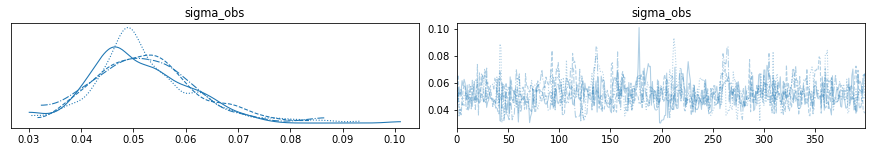

In [6]:
az.plot_trace(trace.posterior["sigma_obs"])

# SEIR Model with R_eff from Spline

In [68]:
coords = {}
if False:
    coords["cpx"] = np.linspace(0,70,8,"float64")
    coords["space"] = np.linspace(8,51,44,"float64")
else:
    coords["cpx"] = pd.date_range(datetime.date(2020,1,30),datetime.date(2020,5,16),freq="SM")
    coords["space"] = pd.date_range(datetime.date(2020,2,20),datetime.date(2020,4,5),freq="D")

print(coords["cpx"],len(coords["cpx"]))
print(coords["space"],len(coords["space"]))

rtest_control = np.array([3,5,6,2,.9,.9,1.1,1.2],"float64")
rtest_spline = Spline(coords["cpx"],tt.cast(rtest_control,"float64").reshape((1,rtest_control.shape[0],)))


t1 = time.time()
rtest_tvalues = rtest_spline.EvaluateAt(coords["space"])[:,0]
rtest_values = rtest_tvalues.eval()
rtest_values += np.random.normal(0, .1, coords["space"].shape[0])
t2 = time.time()
print("Test values in %.3fs"%(t2-t1))


Test values in 2.443s


In [69]:
def tt_lognormal(x, mu, sigma):
# Limit to prevent NANs
    x = tt.clip(x,1e-9,1e12)
    sigma = tt.clip(sigma,1e-9,1e12)
    mu = tt.clip(mu,1e-9,1e12)
    
    distr = 1/x * tt.exp( -( (tt.log(x) - mu) ** 2) / (2 * sigma ** 2))
    return distr / (tt.sum(distr, axis=0) + 1e-12)

def SEIR_model(N, imported_t,Reff_t, median_incubation,sigma_incubation,l=32):
    N = tt.cast(N,'float64')
    beta = tt_lognormal(tt.arange(l), tt.log(median_incubation), sigma_incubation)
    
    # Dirty hack to prevent nan - seems not needed if priors are better
 #   beta = tt.alloc(0,l)
  #  beta = tt.set_subtensor(beta[tt.clip(tt.cast(median_incubation,'int32'),1,l-2)],1)
     
    Reff_t = tt.as_tensor_variable(Reff_t)
    imported_t = tt.as_tensor_variable(imported_t)

    def new_day(Reff_at_t,imported_at_t,infected,E_t,beta,N):
        f = E_t / N
     #   f = 1
        new = imported_at_t + tt.dot(infected,beta) * Reff_at_t * f
        new = tt.clip(new,0,N)
     
        infected = tt.roll(infected,1,0)
        infected = tt.set_subtensor(infected[:1],new,inplace=False)
        E_t = tt.clip(E_t-new,0,E_t)
#        E_t = E_t-new
        return new,infected,E_t
    
    outputs_info = [None,np.zeros(l),N]
    infected_t,updates = theano.scan(fn=new_day,
                                     sequences=[Reff_t,imported_t],
                                     outputs_info=outputs_info,
                                     non_sequences=[beta,N],
                                     profile=False)
                                     
    return infected_t

[4.65336927 4.70476505 5.1226828  5.17847269 5.29174816 5.47856763
 5.67442045 5.88318584 5.9093799  6.1006976  6.0864333  6.13609417
 6.06889049 5.66723853 5.40181365 5.12600891 4.67455494 4.24119395
 3.56590095 3.25073391 2.71698861 2.2590196  2.11415051 1.7304035
 1.66547506 1.38545686 1.32207846 1.14596056 1.04007855 1.00954135
 0.91677545 0.98847982 0.81457279 0.82496613 0.72113186 0.74192111
 0.68074925 0.67095532 0.61912847 0.92528189 0.93787561 0.93918628
 0.85916551 0.87781255]
[  6.           6.           4.00000073   2.02529635   2.00129369
   5.41184718  12.77562884  19.14275358  20.97306582  20.78225378
  22.35281133  32.2092311   50.38955304  68.08757328  83.03947384
  93.6088028  102.6159128  119.90951077 135.47455255 163.44423635
 172.43724271 172.58931555 188.84012839 178.59144819 198.03976001
 187.22648516 197.73456193 185.00649512 177.34870226 179.35871474
 167.90090136 184.85989006 153.62941233 154.69134676 133.22051667
 134.59753223 121.59445175 117.25954759 104.45

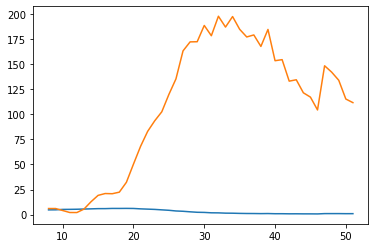

In [70]:
initial = tt.zeros_like(rtest_tvalues)
initial = tt.set_subtensor(initial[:5],tt.cast([6,6,4,2,1],"float64"))

new,infected,E_t = SEIR_model(83e8,initial,rtest_values,6,.3)

new_infected = new.eval()
new_infected += np.random.normal(0, .3, coords["space"].shape[0])

print(rtest_values)
print(new_infected)

plt.plot(coords["space"],rtest_values)
plt.plot(coords["space"],new_infected)

In [71]:
t2 = time.time()

with pm.Model(coords=coords) as model:
    
    sigma_control = pm.Lognormal("sigma_control",mu=tt.log(2),sigma=1.)
    
    est_control = pm.Normal("est_control",mu=0,sigma=sigma_control,dims=("cpx"))
    est_control = tt.exp(tt.cumsum(est_control))
    
    est_spline = Spline(coords["cpx"],est_control.reshape((1,coords["cpx"].shape[0],)))
    est_values = est_spline.EvaluateAt(coords["space"])[:,0]
    
    est_new,est_infected,est_E_t = SEIR_model(83e8,initial,est_values,6,.3)
    
    pm.Deterministic("est_control_sum",est_control)
    pm.Deterministic("est_values",est_values)
    pm.Deterministic("est_new",est_new)

    sigma_obs = pm.HalfCauchy(name="sigma_obs",beta=2)
    pm.StudentT("est",nu=4,sigma=tt.abs_(est_new+1.)**.5 * sigma_obs,mu=est_new,observed=new_infected)
    
    trace = pm.sample(init="advi",return_inferencedata=True,tune=200,draws=200,cores=4,chains=4,max_treedepth=12,target_accept=.95)

t3 = time.time()
print("Compiled and Sampled in %.3f"%(t3-t2))

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 11500
Interrupted at 11,499 [5%]: Average Loss = 404.84
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, est_control, sigma_control]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 799 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Compiled and Sampled in 953.945


<xarray.DataArray 'est_control_sum' (quantile: 3, est_control_sum_dim_0: 8)>
array([[2.24396946, 4.76369688, 6.05237218, 2.0156645 , 0.81561943,
        0.85831279, 0.77298279, 0.79934968],
       [0.63065904, 3.77587362, 5.81697127, 1.96285494, 0.78102415,
        0.81473614, 0.1665565 , 0.07212646],
       [7.68560195, 5.79335325, 6.28164826, 2.07080659, 0.85041737,
        0.91376044, 2.04115803, 5.609503  ]])
Coordinates:
  * est_control_sum_dim_0  (est_control_sum_dim_0) int64 0 1 2 3 4 5 6 7
  * quantile               (quantile) float64 0.5 0.05 0.95


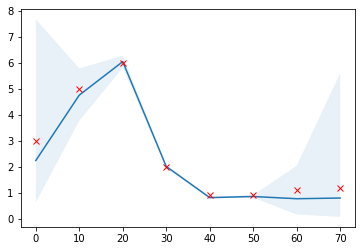

In [72]:
q = trace.posterior["est_control_sum"].quantile((0.5,.05,.95),["chain","draw"])

plt.plot(coords["cpx"],q[0])
plt.fill_between(coords["cpx"],q[1],q[2],alpha=.1)

print(q)
plt.plot(coords["cpx"],rtest_control,"rx")

array([[<AxesSubplot:title={'center':'est_control'}>,
        <AxesSubplot:title={'center':'est_control'}>]], dtype=object)

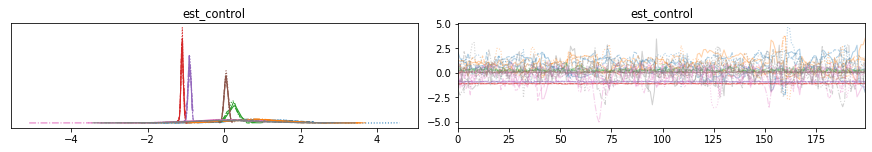

In [73]:
az.plot_trace(trace.posterior["est_control"])

<xarray.DataArray 'est_new' (quantile: 3, est_new_dim_0: 44)>
array([[  6.        ,   6.        ,   4.00000068,   2.02412154,
          1.97392061,   5.29825896,  12.53421125,  18.76734579,
         21.05105461,  20.59984586,  22.34426948,  31.72951804,
         49.44738402,  69.35233623,  84.2492807 ,  93.22087488,
        101.97636499, 117.31872563, 139.22599833, 160.54791674,
        173.66615275, 177.88748964, 179.4336675 , 183.516054  ,
        188.24818251, 191.98906549, 192.50927052, 189.21021195,
        183.40779888, 176.6025858 , 169.55579065, 162.12431564,
        153.22978006, 144.65790014, 138.1888166 , 134.0150631 ,
        131.63634238, 129.92841097, 128.26129898, 126.43541735,
        124.16119777, 121.55365567, 118.34953357, 114.80511648],
       [  6.        ,   6.        ,   4.00000054,   2.019782  ,
          1.82503446,   4.63512042,  11.36847321,  17.54324181,
         20.21018079,  20.02206452,  21.4669347 ,  30.04498356,
         47.12610752,  67.24766238,  82.4

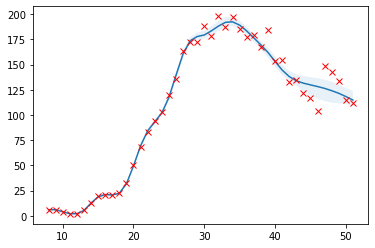

In [74]:
q = trace.posterior["est_new"].quantile((0.5,.05,.95),["chain","draw"])

plt.plot(coords["space"],q[0])
plt.fill_between(coords["space"],q[1],q[2],alpha=.1)

print(q)
plt.plot(coords["space"],new_infected,"rx")

array([[<AxesSubplot:title={'center':'sigma_control'}>,
        <AxesSubplot:title={'center':'sigma_control'}>]], dtype=object)

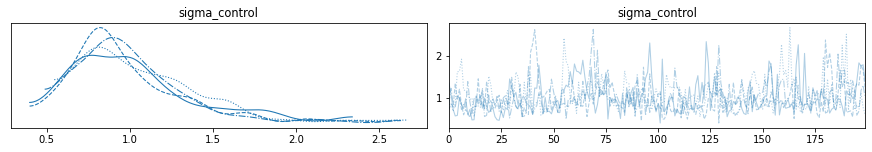

In [75]:
az.plot_trace(trace.posterior["sigma_control"])

array([[<AxesSubplot:title={'center':'sigma_obs'}>,
        <AxesSubplot:title={'center':'sigma_obs'}>]], dtype=object)

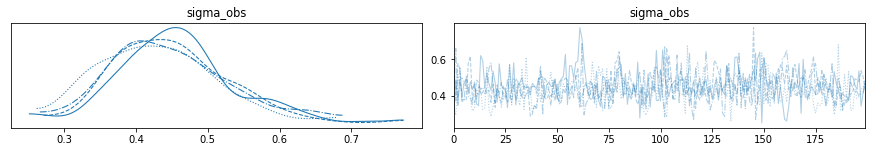

In [76]:
az.plot_trace(trace.posterior["sigma_obs"])